<a href="https://colab.research.google.com/github/klara0036505959/Mini-PhotoMath/blob/master/jupyter_notebooks/final_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
class Conversion:

	def __init__(self, capacity):
		self.top = -1
		self.capacity = capacity
		self.array = []
		self.output = []
		self.precedence = {'+':1, '-':1, '*':2, '/':2, '^':3}
	
	def isEmpty(self):
		return True if self.top == -1 else False
	
	def peek(self):
		return self.array[-1]
	
	def pop(self):
		if not self.isEmpty():
			self.top -= 1
			return self.array.pop()
		else:
			return "$"

	def push(self, op):
		self.top += 1
		self.array.append(op)

	def isOperand(self, ch):
		return ch not in {"+", "-", "*", "/", "(", ")"}

	def notGreater(self, i):
		try:
			a = self.precedence[i]
			b = self.precedence[self.peek()]
			return True if a <= b else False
		except KeyError:
			return False

	def infixToPostfix(self, exp):		
		for i in exp.split(' '):
			if self.isOperand(i):
				self.output.append(i)
			
			elif i == '(':
				self.push(i)
    
			elif i == ')':
				while( (not self.isEmpty()) and
								self.peek() != '('):
					a = self.pop()
					self.output.append(a)
				if (not self.isEmpty() and self.peek() != '('):
					return -1
				else:
					self.pop()

			else:
				while(not self.isEmpty() and self.notGreater(i)):
					self.output.append(self.pop())
				self.push(i)

		while not self.isEmpty():
			self.output.append(self.pop())

		return (" ".join(self.output))
  
class evalpostfix:
	def __init__(self):
		self.stack =[]
		self.top =-1
	def pop(self):
		if self.top ==-1:
			return
		else:
			self.top-= 1
			return self.stack.pop()
	def push(self, i):
		self.top+= 1
		self.stack.append(i)

	def centralfunc(self, ab):
		for i in ab.split(' '):
			try:
				self.push(int(i))
			except ValueError:
				val1 = self.pop()
				val2 = self.pop()
				switcher ={'+':val2 + val1, '-':val2-val1, '*':val2 * val1, '/':val2 / val1, '^':val2**val1}
				self.push(switcher.get(i))
		return int(self.pop())

#imamo problem za negativne brojeve
#fixat cemo provjerom je li minus u sredini izmedu dva broja ili izmedu operatora- sto ne valja
def fix_neg_numbers(str1):
  final = str1
  for i in range(0, len(str1)-1):
    if (str1[i] == "-"):
      if (i == 0 or str1[i-2] in {"+", "-", "*", "/", "(", ")"}):
        str1 = str1[:i+1] + "&" + str1[i+2:]
  return str1.replace("&", "")

def fix_multidigit_numbers(str1):
  import copy
  orig = copy.deepcopy(str1)
  for i in range(0, len(str1)-1):
    if ((str1[i]) in  {str(x) for x in range(10)}):
      if ((str1[i+2]) in  {str(x) for x in range(10)}):
        str1 = str1[:i+1] + "&" + str1[i+2:]
  return str1.replace("&", ""), orig

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


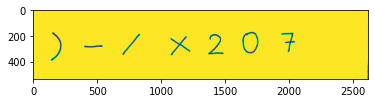

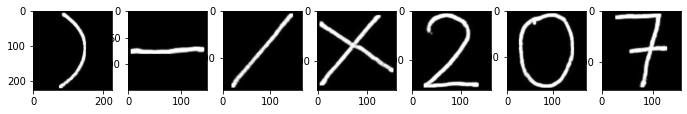

Prediction: ) - / * 2 0 7
Fixed for multidigit numbers: ) -/ * 207





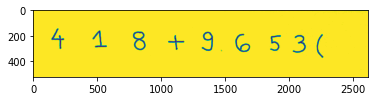

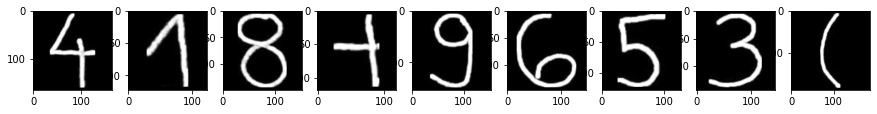

Prediction: 4 9 8 3 9 6 5 3 (
Fixed for multidigit numbers: 49839653 (





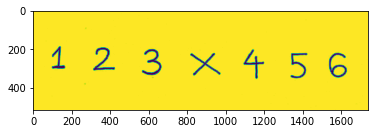

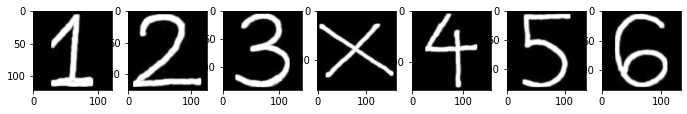

Prediction: 1 2 3 * 4 5 6
Fixed for multidigit numbers: 123 * 456
EVALUATED EXPRESSION: 56088





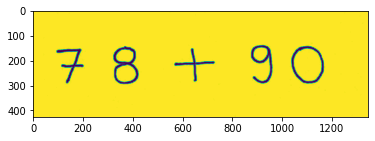

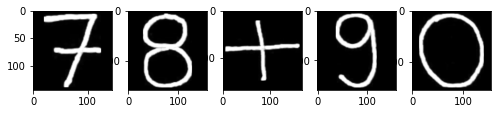

Prediction: 7 8 + 9 0
Fixed for multidigit numbers: 78 + 90
EVALUATED EXPRESSION: 168





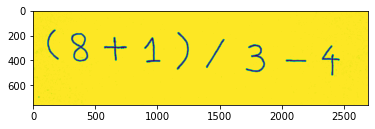

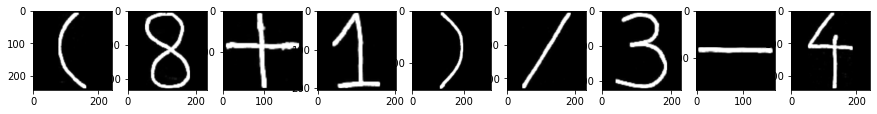

Prediction: ( 8 + 1 ) / 3 - 4
EVALUATED EXPRESSION: -1





In [18]:
from google.colab import drive
drive.mount('/content/drive')
import cv2
import numpy as np
from matplotlib import pyplot as plt
import itertools
import pandas as pd
import PIL
import tensorflow as tf
from PIL import Image
#from preprocess import rescale_segment as rescale_segment
#from preprocess import extract_segments as extract_segments
def rescale_segment( segment, size = [28,28], pad = 0 ):
    '''function for resizing (scaling down) images
    input parameters
    seg : the segment of image (np.array)
    size : out size (list of two integers)
    output 
    scaled down image'''
    if len(segment.shape) == 3 : # Non Binary Image
        import cv2
        # thresholding the image
        ret,segment = cv2.threshold(segment,127,255,cv2.THRESH_BINARY)
    m,n = segment.shape
    idx1 = list(range(0,m, (m)//(size[0]) ) )
    idx2 = list(range(0,n, n//(size[1]) )) 
    out = np.zeros(size)
    for i in range(size[0]):
        for j in range(size[1]):
            out[i,j] = segment[ idx1[i] + (m%size[0])//2, idx2[j] + (n%size[0])//2]
    return out

def pad_along_axis(array: np.ndarray, target_length: int, axis: int = 0):

    pad_size = (target_length - array.shape[axis]) // 2
    remaining = (target_length - array.shape[axis]) % 2

    if pad_size <= 0:
        return array

    npad = [(0, 0)] * array.ndim
    npad[axis] = (pad_size , pad_size + remaining)

    return np.pad(array, pad_width=npad, mode='constant', constant_values=0)


def extract_segments(img, pad=30, reshape = 0,size = [28,28], area = 150, threshold = 100, 
                     gray = False, dil = True, ker = 1, squared = 1) :
    '''function to extract individual chacters and digits from an image
    input paramterts
    img : input image (numpy array)
    pad : padding window size around segments (int)
    size : out size (list of two integers)
    reshape : if 1 , output will be scaled down. if 0, no scaling down
    area : Minimum area requirement for connected component detection
    thresh : gray scale to binary threshold value
    gray : if False, the segments returned will be binary, else will be gray scale
    dil : if True, performs dilation on segments, else erosion
    ker : dimesnion of kernel size for dilation / erosion
    Returns
    out : list of each segments (starting from leftmost digit)'''
    
    import cv2
    
    # thresholding the image
    ret,thresh1 = cv2.threshold(img,threshold,255,cv2.THRESH_BINARY)
    
    # Negative tranform gray levels (background becomes black) 
    thresh1 = 255 - thresh1
    img = 255 - img

    # connected component labelling 
    output = cv2.connectedComponentsWithStats(thresh1, 4)
    final = []
    cords_of_segments = []
    temp2 = output[2]

    #ova linija mozda ne treba
    temp2 = temp2[temp2[:,4]>area]

    temp1 = np.sort( temp2[:,0] )
    kernel = np.ones( [ker, ker])

    for i in range(1,temp2.shape[0]):
        cord = np.squeeze( temp2[temp2[:,0] == temp1[i]] )
#         import pdb; pdb.set_trace()
#         print(cord)
    
        if gray == False:
            num = np.pad( thresh1[ cord[1]:cord[1]+cord[3], cord[0]:cord[0]+cord[2] ], pad,'constant')
        else :
            num = np.pad( img[ cord[1]:cord[1]+cord[3], cord[0]:cord[0]+cord[2] ], pad,'constant')

        if dil :
            num = cv2.dilate(num,kernel,iterations = 1)
        else :
            num = cv2.erode(num,kernel,iterations = 1)

        if reshape == 1:
            num = rescale_segment( num, size )
        if squared == 1:
            x,y = num.shape[0], num.shape[1]
            desired = max(x,y)
            axis = 0 if x < y else 1
            num = pad_along_axis(num, desired, axis)
        final.append(num/255)
        #x,y,w,h
        cords_of_segments.append((cord[0], cord[1], cord[2], cord[3]))
        
    return final, cords_of_segments

class_names = ['/', '(', ')', '+', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '*']
model = tf.keras.models.load_model('/content/drive/My Drive/my_model_good_2.h5')
#model = tf.keras.models.load_model('/content/drive/My Drive/checkpoint_new_lr.h5')

for i in range(1,6):
    im1 = 0
    im1 = cv2.imread('/content/drive/My Drive/test' +str(i)+ '.jpg',0)
    kernel = np.ones( [3,3])
    im1 = cv2.erode(im1,kernel,iterations = 1)
    plt.imshow(im1)
    segments, cords_of_segments = extract_segments(im1, pad = 5, reshape = 0, size = [28,28], 
                               threshold = 40, area = 800, ker = 1, gray = True, squared = 1)
    
    plt.figure(figsize=[15,15])
    plt.subplot(191)
    #plt.imshow(im1,cmap = 'gray')   
    expressions = []
    final_predictions = ""
    for j in range(len(segments)):
        plt.subplot(191+j)
        plt.imshow(segments[j],cmap = 'gray')
        #plt.figure(figsize=[1,1])
        #plt.imshow(segments[j],cmap = 'gray')
        img = Image.fromarray((segments[j]*255).astype(np.uint8))
        #img = Image.fromarray(im)
        img = img.resize(size=(28, 28))
        img_np = np.array(img)
        img_np = img_np /255
        #print(np.max(img_np))
        img_array = np.expand_dims(img_np, axis=0)
        img_array = tf.convert_to_tensor(img_array, dtype=tf.float32)

        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])
        final_predictions += str(class_names[np.argmax(score)]) + " "
        
    plt.show()
    final_predictions = final_predictions[:-1]
    print("Prediction: " + final_predictions)
    
    string = fix_neg_numbers(final_predictions)
    string, prev = fix_multidigit_numbers(string)
    if (string != prev): print("Fixed for multidigit numbers: " + string)
    obj = Conversion(len(string))
    string = obj.infixToPostfix(string)
    try:
      obj = evalpostfix()
      sol = obj.centralfunc(string)
      print("EVALUATED EXPRESSION: "+ str(sol))
    except:
      print("\n\n")
      continue
    
    print("\n\n")
  